# Object Detection for Indonesian Identity Card (KTP)



---


In this notebook we will build a tensorflow model to identify where to retrieve any information. We only use data in the form of **NIK, NAME, GENDER, MARRIAGE STATUS, and CITIZENSHIP**. We will use the **TensorFlow 1.5 Object Detection API** and **MobileNetSSDv2**.

## Configs and Hyperparameters


---


Pretrained model from [TensorFlow 1 Detection Model Zoo in COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md)

Pipeline config files in [models/research/object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs)

In [ ]:
# Url to clone this repo.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps
num_steps = 100000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 16
    }
}

# Select ssd_mobilenet_v2 in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [ ]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Clone the tensorflow-object-detection repository.

In [ ]:
import os

%cd /content
!rm -rf tensorflow-object-detection-faster-rcnn

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 35.52 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [ ]:
%cd /content
!rm -rf models

!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!pip install numpy==1.19.5
!pip uninstall -y pycocotools
!pip install pycocotools --no-binary pycocotools

!python object_detection/builders/model_builder_test.py

!pip install opencv-python
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 5.2 MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking pytho

Found existing installation: pycocotools 2.0.4
Uninstalling pycocotools-2.0.4:
  Successfully uninstalled pycocotools-2.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=265216 sha256=7f5c56f40569a4a4c9f743002a254ea35b9ecd40b14c0348c12e8a7ce62b1208
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools
Using TensorFlow backend.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 55.7 MB/s 


## Preparing Our Images and Annotations


---
Our datasets are processed in Roboflow by creating individual annotated labels and adding images. Roboflow can export datasets in the form of TFRecord files.

Since we need one TFRecord file for training data and one TFRecord file for validation/testing data, we will create two separate data sets in Roboflow and generate a TFRecord set for training and validation/testing (TFRecord and label map.pbtxt).



In [ ]:
%cd /content
!rm -rf dataset
!mkdir dataset
%cd /content/dataset

/content
/content/dataset


In [ ]:
# Installing Roboflow
!pip install -q roboflow

     |████████████████████████████████| 145 kB 5.1 MB/s 
     |████████████████████████████████| 178 kB 46.8 MB/s 
     |████████████████████████████████| 1.1 MB 40.7 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 138 kB 61.0 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which

In [ ]:
#Downloading data from Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="SXKaY7lyLrKyC4UwuCji")
project = rf.workspace("ktp-2wl90").project("final-ktp-od")
dataset = project.version(2).download("tfrecord")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to FInal-KTP-OD-2 in tfrecord:: 100%|██████████| 8/8 [00:00<00:00, 85.50it/s]


In [ ]:
# Directory of the dataset in the form of tfrecord and label map
test_record_fname = '/content/dataset/FInal-KTP-OD-2/valid/NIK.tfrecord'
train_record_fname = '/content/dataset/FInal-KTP-OD-2/train/NIK.tfrecord'
label_map_pbtxt_fname = '/content/dataset/FInal-KTP-OD-2/train/NIK_label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 23 root   root  4.0K May 24 02:23 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 5
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [ ]:
model_dir = 'training/'

!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Train the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Streaming output truncated to the last 5000 lines.
I0524 04:29:59.202781 140340794607488 basic_session_run_hooks.py:692] global_step/sec: 4.5449
INFO:tensorflow:loss = 2.0026429, step = 33500 (22.003 sec)
I0524 04:29:59.203830 140340794607488 basic_session_run_hooks.py:260] loss = 2.0026429, step = 33500 (22.003 sec)
INFO:tensorflow:global_step/sec: 4.55435
I0524 04:30:21.159777 140340794607488 basic_session_run_hooks.py:692] global_step/sec: 4.55435
INFO:tensorflow:loss = 2.4432068, step = 33600 (21.957 sec)
I0524 04:30:21.160792 140340794607488 basic_session_run_hooks.py:260] loss = 2.4432068, step = 33600 (21.957 sec)
INFO:tensorflow:global_step/sec: 4.54801
I0524 04:30:43.147423 140340794607488 basic_session_run_hooks.py:692] global_step/sec: 4.54801
INFO:tensorflow:loss = 1.9283096, step = 33700 (21.988 sec)
I0524 04:30:43.148544 140340794607488 basic_session_run_hooks.py:260] loss = 1.9283096, step = 33700 (21.988 sec)
INFO:tensorflow:global_step/sec: 4.54118
I0524 04:31:05.16810

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1653359036.3e9b3ed4a748
export
graph.pbtxt
model.ckpt-100000.data-00000-of-00001
model.ckpt-100000.index
model.ckpt-100000.meta
model.ckpt-90748.data-00000-of-00001
model.ckpt-90748.index
model.ckpt-90748.meta
model.ckpt-93420.data-00000-of-00001
model.ckpt-93420.index
model.ckpt-93420.meta
model.ckpt-96128.data-00000-of-00001
model.ckpt-96128.index
model.ckpt-96128.meta
model.ckpt-98910.data-00000-of-00001
model.ckpt-98910.index
model.ckpt-98910.meta


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {model_dir}

## Exporting a Trained Inference Graph

---


Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
%cd /content/models/research

import re
import numpy as np

output_directory = './fine_tuned_model'
tflite_directory = './fine_tuned_model/tflite'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

/content/models/research
training/model.ckpt-100000


### Export Inference Graph
---

Export the model to inference graph (.pb file)

In [ ]:
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

Using TensorFlow backend.
Instructions for updating:
Please use `layer.__call__` method instead.
W0524 08:40:40.587748 140668661499776 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0524 08:40:42.992019 140668661499776 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0524 08:40:43.033501 140668661499776 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0524 08:40:43.075185 140668661499776 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

### Export tflite SSD Graph
---

Before converting model to tflite format we need to export the model to TFLite compatible graph (.pb file).

In [ ]:
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={tflite_directory} \
    --trained_checkpoint_prefix={last_model_path}

Using TensorFlow backend.
Instructions for updating:
Please use `layer.__call__` method instead.
W0524 08:40:56.879525 139635585415040 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0524 08:40:59.348386 139635585415040 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0524 08:40:59.382466 139635585415040 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0524 08:40:59.416607 139635585415040 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta   tflite
model.ckpt.data-00000-of-00001	pipeline.config


## Run inference test

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
print(pb_fname)
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

/content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# This is needed to display the images.
%matplotlib inline

In [ ]:
!rm -rf /content/test_data
!mkdir /content/test_data
%cd /content/test_data

from google.colab import files

# Upload data for testing data
uploaded = files.upload()

/content/test_data


Saving fay_0005.jpg to fay_0005.jpg
Saving ian_0004_zoom.jpg to ian_0004_zoom.jpg
Saving train_0002_zoom.jpg to train_0002_zoom.jpg
Saving train_0006_zoom.jpg to train_0006_zoom.jpg


/content/test_data/train_0002_zoom.jpg


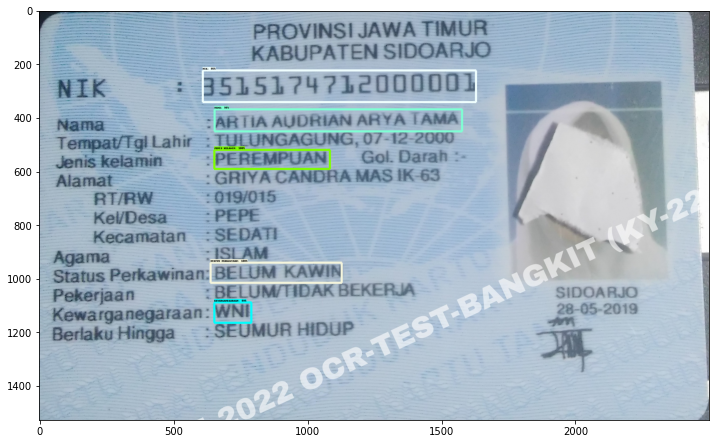

/content/test_data/train_0006_zoom.jpg


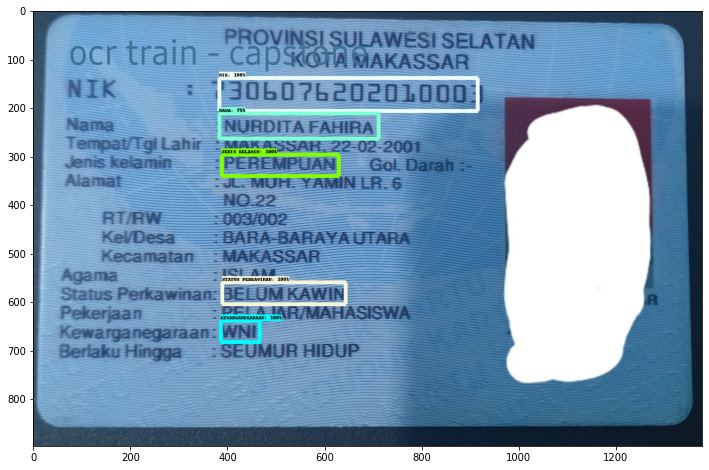

/content/test_data/ian_0004_zoom.jpg


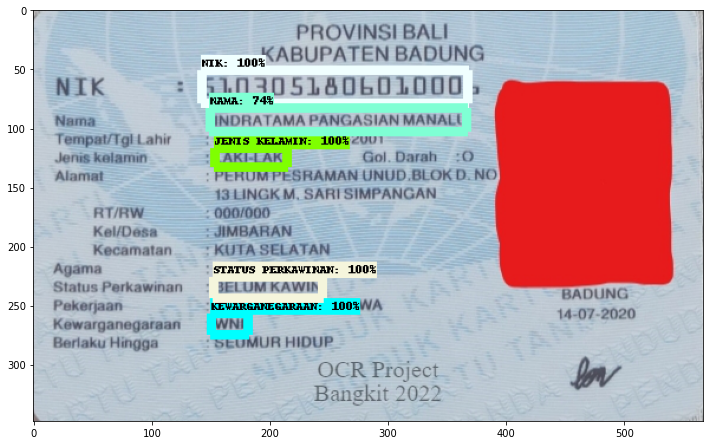

/content/test_data/fay_0005.jpg


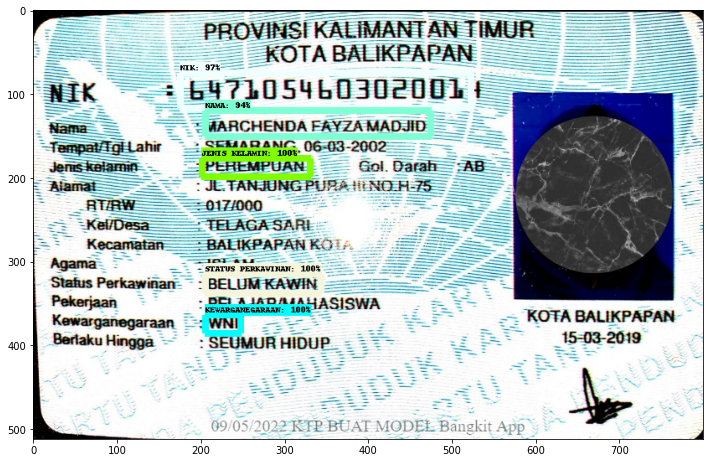

In [ ]:
# Directory dataset for testing data
directory = '/content/test_data/'
!rm -rf .ipynb_checkpoints/

for file_image in os.listdir(directory):
  # Directory image file
  image_path = os.path.join(directory, file_image)
  image = Image.open(image_path)
  print(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()

## Convert to tflite
---

Convert tflite_graph.pb to TFLite

In [ ]:
%ls /content/models/research/fine_tuned_model/tflite

tflite_graph.pb  tflite_graph.pbtxt


In [ ]:
!tflite_convert \
  --input_shape=1,300,300,3 \
  --input_arrays=normalized_input_image_tensor \
  --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
  --allow_custom_ops \
  --graph_def_file=/content/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/models/research/fine_tuned_model/final_model.tflite"

2022-05-24 09:46:46.107169: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-24 09:46:46.112135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 09:46:46.113074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2022-05-24 09:46:46.113347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-24 09:46:46.115681: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-24 09:46:46.116729: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuf

In [ ]:
!tflite_convert \
  --graph_def_file=/content/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/models/research/fine_tuned_model/final_model-quantized-float.tflite" \
  --output_format=TFLITE \
  --input_arrays=normalized_input_image_tensor \
  --input_shapes=1,300,300,3 \
  --inference_type=FLOAT \
  --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
  --allow_custom_ops

2022-05-24 09:46:52.950600: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-24 09:46:52.955741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 09:46:52.956589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2022-05-24 09:46:52.956837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-24 09:46:52.958703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-24 09:46:52.959854: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuf

## TensorFlow Lite Metadata Writer API


---

TensorFlow Lite Model Metadata is a standard model description format. It contains rich semantics for general model information, inputs/outputs, and associated files, which makes the model self-descriptive and exchangeable.

### Prerequisites

In [ ]:
# Install the TensorFlow Lite Support Pypi package.
!pip install tflite-support-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.5 MB 63.5 MB/s 
     |████████████████████████████████| 1.0 MB 55.0 MB/s 
     |████████████████████████████████| 15.7 MB 49.6 MB/s 
     |████████████████████████████████| 213 kB 54.0 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10

### Create Model Metadata for Task Library and Codegen
---

See the [object detector model compatibility requirements](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector#model_compatibility_requirements) for more details about the supported model format.

In [ ]:
# Import the required packages.
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

In [ ]:
%cd /content/models/research/fine_tuned_model/

from google.colab import files

# Upload label_ktp.txt for label file
uploaded = files.upload()

/content/models/research/fine_tuned_model


Saving label_ktp.txt to label_ktp.txt


In [ ]:
ObjectDetectorWriter = object_detector.MetadataWriter
_MODEL_PATH = "/content/models/research/fine_tuned_model/final_model.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "/content/models/research/fine_tuned_model/label_ktp.txt"
_SAVE_TO_PATH = "/content/models/research/fine_tuned_model/final_model_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ObjectDetector",
  "description": "Identify which of a known set of objects might be present and provide information about their positions within the given image or a video stream.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be detected.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
     

## Download Final Model

In [ ]:
!rm -rf /content/fine_tuned_model
# Copy folder to content
!cp -av "/content/models/research/fine_tuned_model" "/content/fine_tuned_model"

'/content/models/research/fine_tuned_model' -> '/content/fine_tuned_model'
'/content/models/research/fine_tuned_model/model.ckpt.data-00000-of-00001' -> '/content/fine_tuned_model/model.ckpt.data-00000-of-00001'
'/content/models/research/fine_tuned_model/model.ckpt.index' -> '/content/fine_tuned_model/model.ckpt.index'
'/content/models/research/fine_tuned_model/checkpoint' -> '/content/fine_tuned_model/checkpoint'
'/content/models/research/fine_tuned_model/model.ckpt.meta' -> '/content/fine_tuned_model/model.ckpt.meta'
'/content/models/research/fine_tuned_model/frozen_inference_graph.pb' -> '/content/fine_tuned_model/frozen_inference_graph.pb'
'/content/models/research/fine_tuned_model/saved_model' -> '/content/fine_tuned_model/saved_model'
'/content/models/research/fine_tuned_model/saved_model/variables' -> '/content/fine_tuned_model/saved_model/variables'
'/content/models/research/fine_tuned_model/saved_model/saved_model.pb' -> '/content/fine_tuned_model/saved_model/saved_model.pb'
'

In [ ]:
# Zip a folder
!zip -r "/content/final_model.zip" "/content/fine_tuned_model"

  adding: content/fine_tuned_model/ (stored 0%)
  adding: content/fine_tuned_model/model.ckpt.data-00000-of-00001 (deflated 7%)
  adding: content/fine_tuned_model/model.ckpt.index (deflated 68%)
  adding: content/fine_tuned_model/saved_model/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/variables/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/saved_model.pb (deflated 10%)
  adding: content/fine_tuned_model/label_ktp.txt (deflated 5%)
  adding: content/fine_tuned_model/tflite/ (stored 0%)
  adding: content/fine_tuned_model/tflite/tflite_graph.pbtxt (deflated 56%)
  adding: content/fine_tuned_model/tflite/tflite_graph.pb (deflated 8%)
  adding: content/fine_tuned_model/pipeline.config (deflated 69%)
  adding: content/fine_tuned_model/model.ckpt.meta (deflated 93%)
  adding: content/fine_tuned_model/final_model_metadata.tflite (deflated 8%)
  adding: content/fine_tuned_model/frozen_inference_graph.pb (deflated 10%)
  adding: content/fine_tuned_model/final_model-

In [ ]:
from google.colab import files

# Download zip file
files.download('/content/final_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>